## Problem 1 Solution

$$
\begin{align}
min  f= x_1^2+(x_2-3)^2\\
s.t. g_1= x_2^2-2x_1\leq 0\\
     g_2= (x_2-1)^2+5x_1-15\leq 0\\
\end{align}
$$
SQP algorithm with line search to solve this problem, starting from
${\bf x}_0=(1,1)^T$ is implemented and the merit function and Armijo Line Search were utilized to find the step size. 
BFGS approximation was used for the Hessian of the Lagrangian, QP sub problem was incorporated. 

The detailed code is attached below:

<IPython.core.display.Javascript object>


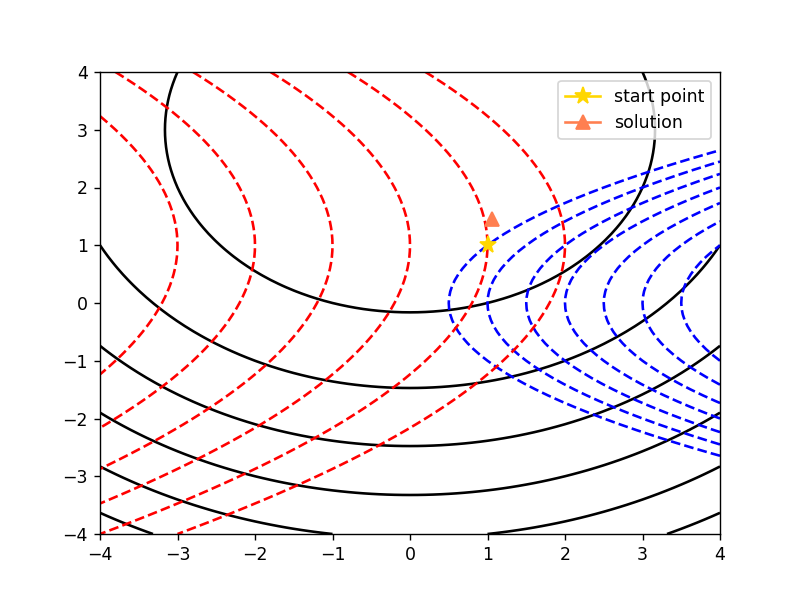

Solution for this problem is: X=(1.0604169033539967,1.4563356389457212)


In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import copy

def objective_f(x):
    f = x[0][0] ** 2 + (x[1][0] - 3) ** 2
    return f

def objective_df(x):
    df = np.array([[2 * x[0][0], 2 * (x[1][0] - 3)]])
    return df

def constraint_dg(x):
    dg = np.array([[-2, 2 * x[1][0]],
                   [5, 2 * (x[1][0] - 1)]])
    return dg

def constraint_g(x):
    g = np.array([[x[1][0] ** 2 - 2 * x[0][0]],
                  [(x[1][0] - 1) ** 2 + 5 * x[0][0] - 15]])
    return g

def line_search(x, s, mu, w_old, k):
    t = 0.3
    a = 1

    # w = np.zeros((2, 1))
    # w[0] = max(abs(mu[0]), 0.5 * (w_last[0] + abs(mu[0])))
    # w[1] = max(abs(mu[1]), 0.5 * (w_last[1] + abs(mu[1])))

    if k == 0:
        w = abs(mu)
    else:
        w = np.zeros((2, 1))
        w[0] = max(abs(mu[0]), 0.5 * (w_old[0] + abs(mu[0])))
        w[1] = max(abs(mu[1]), 0.5 * (w_old[1] + abs(mu[1])))

    dg_da_1 = 0 if constraint_g(x)[0, :] <= 0 else np.matmul(constraint_dg(x)[0, :], s)
    dg_da_2 = 0 if constraint_g(x)[1, :] <= 0 else np.matmul(constraint_dg(x)[1, :], s)
    dF_da = np.matmul(objective_df(x), s) + (w[0, :] * dg_da_1 + w[1, :] * dg_da_2)

    def F_a(x, w, a, s):
        g1 = max(0, constraint_g(x + a*s)[0, :])
        g2 = max(0, constraint_g(x + a*s)[1, :])
        F = objective_f(x + a*s) + (w[0, :] * g1 + w[1, :] * g2)
        return F

    phi = lambda x, w, a, t, dF_da: F_a(x, w, 0, 0) + a * t * dF_da

    while phi(x, w, a, t, dF_da) < F_a(x, w, a, s):
        a = 0.8 * a

    return a, w

def solve_sqp(x, W):
    A0 = constraint_dg(x)
    b0 = constraint_g(x)
    mu0 = np.zeros((b0.shape[0], 1))
    mu = []
    active = []
    while True:
        if len(active) == 0:
            matrix = W
            s_mu = np.matmul(np.linalg.inv(matrix), -objective_df(x).T)
            s = s_mu[:2, :]
            mu = []

        if len(active) != 0:
            if len(active) == 1:
                A = A0[active[0], :].reshape(1, -1)
                b = b0[active[0], :]
            if len(active) == 2:
                A = copy.deepcopy(A0)
                b = copy.deepcopy(b0)
            matrix = np.vstack((np.hstack((W, A.T)),
                                np.hstack((A, np.zeros((A.shape[0], A.shape[0]))))))
            s_mu = np.matmul(np.linalg.inv(matrix), np.vstack((-objective_df(x).T, -b)))
            s = s_mu[:2, :]
            mu = s_mu[2:, :]
            if len(mu) == 1:
                mu0[0] = s_mu[2:3, :]
            if len(mu) == 2:
                mu0[0] = s_mu[2:3, :]
                mu0[1] = s_mu[3:, :]

        sqp_constraint = np.round((np.matmul(A0, s.reshape(-1, 1)) + b0))

        mu_check = 0

        if len(mu) == 0:
            mu_check = 1
        elif min(mu) > 0:
            mu_check = 1
        else:
            id_mu = np.argmin(np.array(mu))
            mu.remove(min(mu))
            active.pop(id_mu)

        if np.max(sqp_constraint) <= 0:
            if mu_check == 1:
                return s, mu0
        else:
            index = np.argmax(sqp_constraint)
            active.append(index)
            active = np.unique(np.array(active)).tolist()


def BFGS(W, x, dx, s, mu):
    delta_L = (objective_df(x) + np.matmul(mu.T, constraint_dg(x))) - (objective_df(x - dx) + np.matmul(mu.T, constraint_dg(x - dx)))
    Q = np.matmul(np.matmul(dx.T, W), dx)
    if np.matmul((dx).T, delta_L.T) >= 0.2 * np.matmul(np.matmul((dx).T, W), (dx)):
        theta = 1
    else:
        theta = 0.8 * Q / (Q - np.matmul(dx.T, delta_L.T))

    y = theta * delta_L.T + (1 - theta) * np.matmul(W, dx)
    W_new = W + np.matmul(y, y.T) / np.matmul(y.T, s) - np.matmul(np.matmul(W, s), np.matmul(s.T, W)) / np.matmul(np.matmul(s.T, W), s)

    return W_new

eps = 1e-3  # termination criterion
x0 = np.array([[1.], [1.]])
x = np.array([[1.], [1.]])
W = np.eye(x.shape[0])
mu_old = np.zeros((x.shape[0], 1))
k = 0

delta_L_norm = np.linalg.norm(objective_df(x) + np.matmul(mu_old.T, constraint_dg(x)))
w_old = np.zeros((2, 1))
solution1 = []
solution2 = []
solution1.append(x[0][0])
solution2.append(x[1][0])

while delta_L_norm > eps:
    s, mu_new = solve_sqp(x, W)
    a, w_new = line_search(x, s, mu_old, w_old, k)

    w_old = w_new
    dx = a*s
    x += dx
    W = BFGS(W, x, dx, s, mu_new)
    k += 1
    delta_L_norm = np.linalg.norm(objective_df(x) + np.matmul(mu_new.T, constraint_dg(x)))
    mu_old = mu_new
    solution1.append(x[0][0])
    solution2.append(x[1][0])

X1 = np.linspace(-4, 4, 81)
X2 = np.linspace(-4, 4, 81)
x1, x2 = np.meshgrid(X1, X2)

F = np.array([x1 ** 2 + (x2 - 3) ** 2 for x2 in X2 for x1 in X1]).reshape(x1.shape)
G1 = np.array([-2 * x1 + x2 ** 2 for x2 in X2 for x1 in X1]).reshape(x1.shape)
G2 = np.array([5 * x1 + (x2 - 1) ** 2 - 15 for x2 in X2 for x1 in X1]).reshape(x1.shape)

G1[np.where(G1 > 0)] = None
G2[np.where(G2 > 0)] = None

plt.figure(1)
plt.contour(x1, x2, F, colors='k')
plt.contour(x1, x2, G1, colors='b')
plt.contour(x1, x2, G2, colors='r')
plt.plot(x0[0], x0[1], c='gold', marker='*', markersize='10', label='start point')
plt.plot(solution1[-1], solution2[-1], c='coral', marker='^', markersize='8', label='solution')
plt.legend()
plt.show()

print('Solution for this problem is: X=({},{})'.format(solution1[-1], solution2[-1]))